Import required libraries

In [3]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, learning_curve
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import torch


Load the CSV files (Training and Testing)

In [4]:
# Load the normalized training and testing datasets
train_data = pd.read_csv('normalized_dataset_training.csv')  
test_data = pd.read_csv('normalized_dataset_testing.csv')    


Combine datasets for splitting

In [5]:
combined_data = pd.concat([train_data, test_data], axis=0)

# Split combined data into features and labels
features = combined_data.drop(['label', 'attack_cat'], axis=1).values
labels = combined_data['label'].values

# Perform an 80/20 split for training and testing
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)


Check the balance of the dataset (training + testing combined)

In [7]:
combined_labels = combined_data['label']

# Calculate the counts and percentages for each class
class_counts = combined_labels.value_counts()
class_percentages = (class_counts / combined_labels.shape[0]) * 100

class_counts, class_percentages


(label
 1.0    164649
 0.0     92997
 Name: count, dtype: int64,
 label
 1.0    63.905126
 0.0    36.094874
 Name: count, dtype: float64)

Balancing the training data

In [11]:
# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

Class balance

In [13]:
print("Class balance after SMOTE:")
unique, counts = torch.tensor(y_train).unique(return_counts=True)
for cls, count in zip(unique.cpu().numpy(), counts.cpu().numpy()):
    print(f"Class {int(cls)}: {count} ({(count / len(y_train)) * 100:.2f}%)")

Class balance after SMOTE:
Class 0: 131720 (50.00%)
Class 1: 131720 (50.00%)


Train the SVM model

In [15]:
# Initialize the SVM classifier
svm_model = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)

# Fit the model on the training data
svm_model.fit(X_train, y_train)


SVC(C=1, random_state=42)

Evaluate the Model

Confusion Matrix:
[[16966  1635]
 [ 2172 30757]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.91      0.90     18601
         1.0       0.95      0.93      0.94     32929

    accuracy                           0.93     51530
   macro avg       0.92      0.92      0.92     51530
weighted avg       0.93      0.93      0.93     51530


Accuracy Score:
0.9261207063846303
92.61%
Training Accuracy: 92.48%


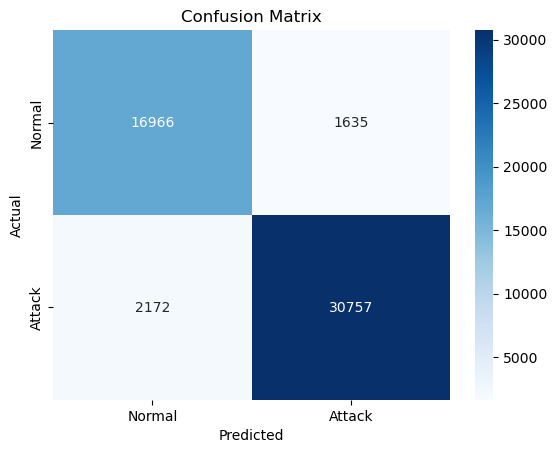

In [24]:
# Predict on the testing data
y_pred = svm_model.predict(X_test)

# Evaluate performance
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

accuracy_percentage = accuracy_score(y_test, y_pred) * 100
print(f"{accuracy_percentage:.2f}%")

y_train_pred = svm_model.predict(X_train)  
training_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {training_accuracy * 100:.2f}%")

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Top-left cell (16966): These are the instances where the actual class is "Normal" and the model correctly predicted "Normal" (True Positives for "Normal").
Top-right cell (1635): These are the instances where the actual class is "Normal," but the model incorrectly predicted "Attack" (False Positives).
Bottom-left cell (2172): These are the instances where the actual class is "Attack," but the model incorrectly predicted "Normal" (False Negatives).
Bottom-right cell (30757): These are the instances where the actual class is "Attack" and the model correctly predicted "Attack" (True Positives for "Attack").

Training vs Testing accuracy for incremental sizes (from 10% to 100% of training data)

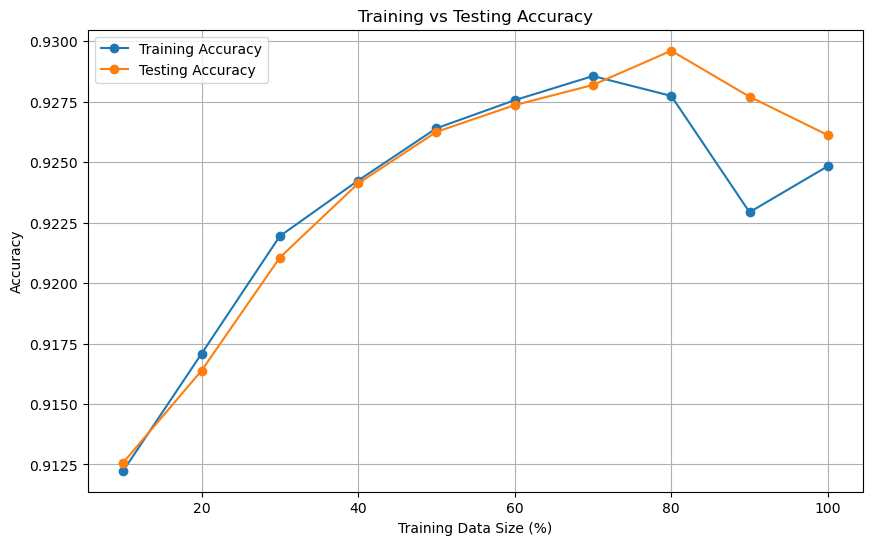

In [18]:
# Initialize lists to store accuracies
training_sizes = np.linspace(0.1, 1.0, 10)  # 10% to 100% of training data
train_accuracies = []
test_accuracies = []

for size in training_sizes:
    # Select a subset of the training data
    subset_size = int(size * len(X_train))
    X_train_subset = X_train[:subset_size]
    y_train_subset = y_train[:subset_size]
    
    # Train the model
    svm_model.fit(X_train_subset, y_train_subset)
    
    # Calculate training accuracy
    y_train_pred = svm_model.predict(X_train_subset)
    train_accuracy = accuracy_score(y_train_subset, y_train_pred)
    train_accuracies.append(train_accuracy)
    
    # Calculate testing accuracy
    
    y_test_pred = svm_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_accuracies.append(test_accuracy)

# Plot the accuracies
plt.figure(figsize=(10, 6))
plt.plot(training_sizes * 100, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(training_sizes * 100, test_accuracies, label='Testing Accuracy', marker='o')
plt.xlabel('Training Data Size (%)')
plt.ylabel('Accuracy')
plt.title('Training vs Testing Accuracy')
plt.legend()
plt.grid()
plt.show()